# Setup env and load data

This is a test project to try different computer vision models (CNN from the scratch, transfer learning etc.). As the test dataset it uses CIFAR-10:
https://www.cs.toronto.edu/~kriz/cifar.html

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.18.0


In [3]:
# Mount Google Drive

from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Paths

In [4]:
from pathlib import Path
import json

path_to_google_drive_dir = Path("drive/MyDrive/ML-practice/computer-vision")

In [5]:
def get_path(name: str) -> Path:
  """
  Get path to the dir/file and
  generate the parent dir if it doesn't exist.
  """
  path = path_to_google_drive_dir / name

  # Create dirs
  if path.is_dir():
    path.mkdir(parents=True, exist_ok=True)
  else:
    path.parent.mkdir(parents=True, exist_ok=True)

  return path

## Dataset

In [6]:
# Import dataset
from tensorflow.keras.datasets import cifar10

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [7]:
X_train[0].shape

(32, 32, 3)

In [8]:
y_train[0]

array([6], dtype=uint8)

In [9]:
# CIFAR-10 class names
class_names = [
    'airplane',   # 0
    'automobile', # 1
    'bird',       # 2
    'cat',        # 3
    'deer',       # 4
    'dog',        # 5
    'frog',       # 6
    'horse',      # 7
    'ship',       # 8
    'truck',      # 9
  ]

In [10]:
INPUT_SHAPE: tuple[int, int, int] = (32, 32, 3)

# Data preprocessing

In [11]:
def show_images(images: np.ndarray,
                labels: np.ndarray,
                class_names: list[str] = class_names,
                n: int = 5) -> None:
    """
    Display a row of images with their class labels.

    Args:
        images (np.array): image data (e.g., X_train)
        labels (np.array): integer labels (e.g., y_train)
        class_names (list): class name list for decoding
        n (int): number of images to show
    """
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(images[i])
        label_index = labels[i] if labels.ndim == 1 else labels[i][0]
        plt.title(class_names[label_index])
        plt.axis('off')
    plt.show()

In [12]:
# show_images(X_train, y_train, n=5)

In [13]:
from tensorflow.keras.utils import to_categorical

# Normalize pixel values
X_train, X_test = X_train / 255.0, X_test / 255.0

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

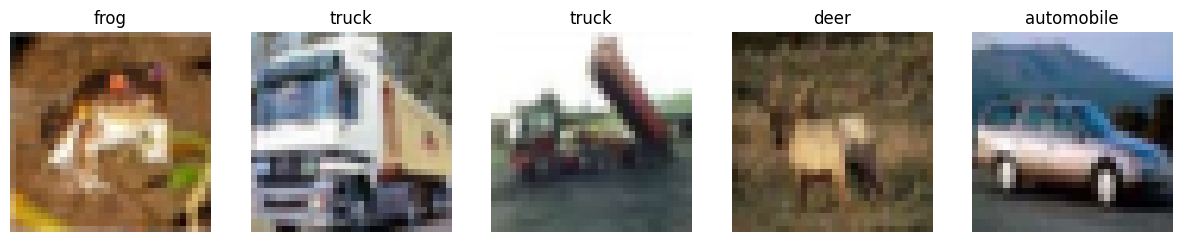

In [14]:
show_images(X_train, y_train, n=5)

#### Data augmentation

In [15]:
# from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation
def create_datagen(rotation_range: int = 15,
                    horizontal_flip: bool = True,
                    width_shift_range: float = 0.1,
                    height_shift_range: float = 0.1) -> ImageDataGenerator:
    return ImageDataGenerator(
        rotation_range=rotation_range,
        horizontal_flip=horizontal_flip,
        width_shift_range=width_shift_range,
        height_shift_range=height_shift_range
    )


# Training

In [16]:
from typing import Callable, Union
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, History
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model

def load_or_train_model(create_fn: Callable[[], Model],
                        model_path: Path,
                        history_path: Path,
                        callbacks: list[Callback],
                        X_train: tf.Tensor,
                        y_train_cat: tf.Tensor,
                        X_test: tf.Tensor,
                        y_test_cat: tf.Tensor,
                        datagen: ImageDataGenerator | None = None,
                        epochs: int = 30) -> tuple[Model, History]:
    """
    Load a saved model or train a new one and save it.

    Args:
        create_fn: function that returns a compiled Keras model.
        model_path: path to the saved model (.keras or .h5).
        datagen: an ImageDataGenerator for data augmentation.
        callbacks: list of Keras callbacks (e.g., EarlyStopping, ModelCheckpoint).
        X_train, y_train_cat: training data (optional augmented using datagen).
        X_test, y_test_cat: validation data.
        epochs: number of training epochs.

    Returns:
        A trained or loaded Keras model.
    """
    try:
        model = load_model(model_path)
        print(f"✅ Loaded saved model from {model_path}")

        history = json.load(open(history_path))
        print(f"✅ Loaded history from {history_path}")

    except Exception as e:
        print(f"⚠️ Could not load model or history: {e}")
        model = create_fn()

        if datagen:

            datagen.fit(X_train)

            history: History = model.fit(
                datagen.flow(X_train, y_train_cat, batch_size=64),
                validation_data=(X_test, y_test_cat),
                epochs=epochs,
                callbacks=callbacks
            )
        else:
            history: History = model.fit(
                X_train,
                y_train_cat,
                validation_data=(X_test, y_test_cat),
                epochs=epochs,
                callbacks=callbacks
            )

        model.save(model_path)
        print(f"💾 Model is saved to {model_path}")

        history_path.write_text(json.dumps(history.history))
        print(f"💾 History is saved to {history_path}")

    return model, history


# Evaluation

## TensorBoard

In [17]:
%load_ext tensorboard

In [18]:
import datetime

# Create a func to build a TensorBoard callback

def create_tensorboard_callback(path_to_logs: Path):
  current_time = datetime.datetime.now().strftime("%Y_%m_%d-%H:%M:%S")
  log_dir = path_to_logs / current_time
  return tf.keras.callbacks.TensorBoard(log_dir)

## Evaluation functions

In [19]:
# Histories dict to collect and compare the metrics
histories: dict[str, tf.keras.callbacks.History] = {}

In [20]:
def plot_confusion_matrix(model_name: str,
                          y_pred: np.ndarray,
                          y_true: np.ndarray) -> None:
    """
    Plot the confusion matrix of a model.
    """
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix for model: " + model_name)
    plt.show()

In [21]:
def plot_training_histories(histories: dict[str, tf.keras.callbacks.History],
                            metric: str = 'accuracy') -> None:
    plt.figure(figsize=(10, 5))
    for name, history in histories.items():
        plt.plot(history.history[metric], label=f'{name} Train')
        plt.plot(history.history[f'val_{metric}'], label=f'{name} Val')
    plt.title(f'{metric.title()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric.title())
    plt.legend()
    plt.grid(True)
    plt.show()

#### Print general metrics

In [22]:
def print_general_metrics(model: Model,
                          model_name: str,
                          model_description: str,
                          to_print_model_summary: bool = True,
                          to_print_classification_report: bool = True,
                          to_plot_confusion_matrix: bool = True) -> None:
    print("\nMODEL:", model_name)
    print(model_description, "\n")

    if to_print_model_summary:
      model.summary()

    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test.flatten()

    if to_print_classification_report:
      print(classification_report(y_true, y_pred))

    if to_plot_confusion_matrix:
      plot_confusion_matrix(model_name, y_pred, y_true)

    print("-------------------------------------------------------------------")

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


def print_accuracy_and_f1_score(model: Model,
                                   model_name: str,
                                   X_test: tf.Tensor = X_test,
                                   y_test: tf.Tensor = y_test) -> None:
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test.flatten()
    print(f"{model_name} -> Accuracy: {accuracy_score(y_true, y_pred)}, performance: {f1_score(y_true, y_pred)}")


In [ ]:
from sklearn.metrics import RocCurveDisplay, roc_curve, auc, roc_auc_score

def plot_roc_auc_score(model: Model,
                        model_name: str,
                        X_test: tf.Tensor = X_test,
                        y_test: tf.Tensor = y_test) -> None:
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test.flatten()
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

In [ ]:
def print_roc_auc_score(model: Model,
                        model_name: str,
                        X_test: tf.Tensor = X_test,
                        y_test: tf.Tensor = y_test) -> None:
    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = y_test.flatten()
    print(f"{model_name} -> ROC AUC score: {roc_auc_score(y_true, y_pred)}")

In [23]:
models_to_evaluate: list[tuple[Model, str, str]] = []  # (model, model_name, description)

# Models

## 1. CNN from scratch

### Constructors

In [24]:
from dataclasses import dataclass, field

@dataclass
class ModelConfigCCNScratch:
    model_name: str = "model_1_scratch_cnn"
    num_classes: int = len(class_names)
    metrics: list[str] = field(default_factory=lambda: ["accuracy"])
    optimizer: str = "adam"
    loss_function: str = "categorical_crossentropy"
    activation_function: str = "relu"
    conv_layers: list[tuple[int, int, int]] = field(default_factory=lambda: [(32, 3, 3), (64, 3, 3)])
    dense_layers: list[int] = field(default_factory=lambda: [64])
    datagen: ImageDataGenerator | None = create_datagen()
    epochs: int = 30
    input_shape: tuple[int, int, int] = INPUT_SHAPE
    create_model_fn: Callable[[], Model] | None = None

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


def train_model_cnn_scratch(
        model_config: ModelConfigCCNScratch,
        X_train_param: tf.Tensor = X_train,
        y_train_param: tf.Tensor = y_train_cat,
        X_test_param: tf.Tensor = X_test,
        y_test_param: tf.Tensor = y_test_cat,
        ) -> None:
    model_description = f"""
    Model with {len(model_config.conv_layers)} conv layers and {len(model_config.dense_layers)} dense layers.
    Data augmentation: {'true' if model_config.datagen else 'false'}.
    Activation function: {model_config.activation_function}.
    Optimizer: {model_config.optimizer}.
    Loss function: {model_config.loss_function}.
    Metrics: {model_config.metrics}.
    """

    model_name = model_config.model_name
    input_shape = model_config.input_shape
    create_model_fn = model_config.create_model_fn
    activation_function = model_config.activation_function
    optimizer = model_config.optimizer
    conv_layers = model_config.conv_layers
    dense_layers = model_config.dense_layers
    loss_function = model_config.loss_function
    metrics = model_config.metrics
    num_classes = model_config.num_classes
    datagen = model_config.datagen

    def create_model_scratch_cnn() -> Model:
        layers = [
            tf.keras.layers.Input(shape=input_shape),
        ]

        for conv_layer in conv_layers:
            layers.append(tf.keras.layers.Conv2D(conv_layer[0], (conv_layer[1], conv_layer[2]), activation=activation_function))
            layers.append(tf.keras.layers.MaxPooling2D())

        layers.append(tf.keras.layers.Flatten())

        for dense_layer in dense_layers:
            layers.append(tf.keras.layers.Dense(dense_layer, activation=activation_function))

        layers.append(tf.keras.layers.Dense(num_classes, activation="softmax"))

        model = tf.keras.Sequential(layers)
        model.compile(optimizer=optimizer, loss=loss_function, metrics=metrics)
        return model

    # Paths
    path_to_model = get_path(f"{model_name}.keras")
    path_to_model_history = get_path(f"{model_name}_history.json")
    path_to_model_logs = get_path(f"{model_name}_logs")

    # Train (load) model
    trained_model, model_history = load_or_train_model(
        create_fn=create_model_fn or create_model_scratch_cnn,
        model_path=path_to_model,
        history_path=path_to_model_history,
        datagen=datagen,
        callbacks=[
            EarlyStopping(patience=5, restore_best_weights=True),
            ModelCheckpoint(str(path_to_model), save_best_only=True),
            create_tensorboard_callback(path_to_model_logs),
        ],
        X_train=X_train_param,
        y_train_cat=y_train_param,
        X_test=X_test_param,
        y_test_cat=y_test_param
    )

    # Save history
    histories[model_name] = model_history
    models_to_evaluate.append((trained_model, model_name, model_description))


### 1.1. Base

In [26]:
model_config = ModelConfigCCNScratch()

train_model_cnn_scratch(model_config=model_config)

✅ Loaded saved model from drive/MyDrive/ML-practice/computer-vision/model_1_scratch_cnn.keras
✅ Loaded history from drive/MyDrive/ML-practice/computer-vision/model_1_scratch_cnn_history.json


In [27]:
# %tensorboard --logdir 'drive/MyDrive/ML-practice/computer-vision/model_1_scratch_cnn_logs'

### 1.2. Base +1 Conv2D layer

In [28]:
model_config = ModelConfigCCNScratch(
    model_name="model_2_scratch_cnn",
    conv_layers=[(32, 3, 3), (64, 3, 3), (128, 3, 3)],
)

train_model_cnn_scratch(model_config=model_config)

✅ Loaded saved model from drive/MyDrive/ML-practice/computer-vision/model_2_scratch_cnn.keras
✅ Loaded history from drive/MyDrive/ML-practice/computer-vision/model_2_scratch_cnn_history.json


In [29]:
# %tensorboard --logdir 'drive/MyDrive/ML-practice/computer-vision/model_2_scratch_cnn_logs'

### 1.3. Base -1 Conv2D layer

In [30]:
model_config = ModelConfigCCNScratch(
    model_name="model_3_scratch_cnn",
    conv_layers=[(32, 3, 3)],
)

train_model_cnn_scratch(model_config=model_config)

✅ Loaded saved model from drive/MyDrive/ML-practice/computer-vision/model_3_scratch_cnn.keras
✅ Loaded history from drive/MyDrive/ML-practice/computer-vision/model_3_scratch_cnn_history.json


### 1.4. Base increased kernel_size (5, 5)

In [31]:
model_config = ModelConfigCCNScratch(
    model_name="model_4_scratch_cnn",
    conv_layers=[(32, 5, 5), (64, 5, 5)],
)

train_model_cnn_scratch(model_config=model_config)

✅ Loaded saved model from drive/MyDrive/ML-practice/computer-vision/model_4_scratch_cnn.keras
✅ Loaded history from drive/MyDrive/ML-practice/computer-vision/model_4_scratch_cnn_history.json


### 1.5. Base with activation_function="tanh"

In [32]:
model_config = ModelConfigCCNScratch(
    model_name="model_5_scratch_cnn",
    activation_function="tanh",
)

train_model_cnn_scratch(model_config=model_config)

✅ Loaded saved model from drive/MyDrive/ML-practice/computer-vision/model_5_scratch_cnn.keras
✅ Loaded history from drive/MyDrive/ML-practice/computer-vision/model_5_scratch_cnn_history.json


### 1.6. Base with activation_function="leaky_relu"

In [33]:
model_config = ModelConfigCCNScratch(
    model_name="model_6_scratch_cnn",
    activation_function="leaky_relu",
)

train_model_cnn_scratch(model_config=model_config)

✅ Loaded saved model from drive/MyDrive/ML-practice/computer-vision/model_6_scratch_cnn.keras
✅ Loaded history from drive/MyDrive/ML-practice/computer-vision/model_6_scratch_cnn_history.json


### 1.7. Base with optimizer="sgd"

In [34]:
model_config = ModelConfigCCNScratch(
    model_name="model_7_scratch_cnn",
    optimizer="sgd",
)

train_model_cnn_scratch(model_config=model_config)

✅ Loaded saved model from drive/MyDrive/ML-practice/computer-vision/model_7_scratch_cnn.keras
✅ Loaded history from drive/MyDrive/ML-practice/computer-vision/model_7_scratch_cnn_history.json


### 1.8. Base with loss_function="sparse_categorical_crossentropy"

In [35]:
model_config = ModelConfigCCNScratch(
    model_name="model_8_scratch_cnn",
    loss_function="sparse_categorical_crossentropy",
)

train_model_cnn_scratch(model_config=model_config, y_test_param=y_test, y_train_param=y_train)

✅ Loaded saved model from drive/MyDrive/ML-practice/computer-vision/model_8_scratch_cnn.keras
✅ Loaded history from drive/MyDrive/ML-practice/computer-vision/model_8_scratch_cnn_history.json


### 1.9. Base with dense_layers=[32]

In [36]:
model_config = ModelConfigCCNScratch(
    model_name="model_9_scratch_cnn",
    dense_layers=[32],
)

train_model_cnn_scratch(model_config=model_config)

⚠️ Could not load model or history: File not found: filepath=drive/MyDrive/ML-practice/computer-vision/model_9_scratch_cnn.keras. Please ensure the file is an accessible `.keras` zip file.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step - accuracy: 0.3331 - loss: 1.8402 - val_accuracy: 0.5055 - val_loss: 1.3907
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 39ms/step - accuracy: 0.4959 - loss: 1.3960 - val_accuracy: 0.5890 - val_loss: 1.1688
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.5528 - loss: 1.2639 - val_accuracy: 0.6050 - val_loss: 1.1252
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.5815 - loss: 1.1836 - val_accuracy: 0.6337 - val_loss: 1.0467
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6003 - loss: 1.1340 - val_accuracy: 0.6385 - val_loss: 1.0408
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 41s 37ms/step - accuracy: 0.6138 - loss: 1.0947 - val_accuracy: 0.6706 - val_loss: 0.9682
Epoch 7/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 41ms/step - accuracy: 0.6292 - loss: 1.0648 - val_accuracy: 0.6628 - val_loss: 0.9897
Epoch 8/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6373 - loss: 1.0356 - 

### 1.10. Base with dense_layers=[128]

In [37]:
model_config = ModelConfigCCNScratch(
    model_name="model_10_scratch_cnn",
    dense_layers=[128],
)

train_model_cnn_scratch(model_config=model_config)

⚠️ Could not load model or history: File not found: filepath=drive/MyDrive/ML-practice/computer-vision/model_10_scratch_cnn.keras. Please ensure the file is an accessible `.keras` zip file.
Epoch 1/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 35s 41ms/step - accuracy: 0.3548 - loss: 1.7545 - val_accuracy: 0.5244 - val_loss: 1.3509
Epoch 2/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 36s 37ms/step - accuracy: 0.5372 - loss: 1.3031 - val_accuracy: 0.6175 - val_loss: 1.0862
Epoch 3/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 32s 40ms/step - accuracy: 0.5843 - loss: 1.1735 - val_accuracy: 0.6482 - val_loss: 1.0078
Epoch 4/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.6114 - loss: 1.0999 - val_accuracy: 0.6339 - val_loss: 1.0453
Epoch 5/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 38ms/step - accuracy: 0.6336 - loss: 1.0391 - val_accuracy: 0.6654 - val_loss: 0.9469
Epoch 6/30
782/782 ━━━━━━━━━━━━━━━━━━━━ 29s 37ms/step - accuracy: 0.6517 - loss: 0.9970 - val_accuracy: 0.6983 - val_loss: 0.8782
Epoch 7/30
782/782 ━━━━━━━━━━━

### 1.11. Base without datagen

In [38]:
model_config = ModelConfigCCNScratch(
    model_name="model_11_scratch_cnn",
    datagen=None,
)

train_model_cnn_scratch(model_config=model_config)

⚠️ Could not load model or history: File not found: filepath=drive/MyDrive/ML-practice/computer-vision/model_11_scratch_cnn.keras. Please ensure the file is an accessible `.keras` zip file.
Epoch 1/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - accuracy: 0.3875 - loss: 1.6826 - val_accuracy: 0.5625 - val_loss: 1.2233
Epoch 2/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6033 - loss: 1.1325 - val_accuracy: 0.6265 - val_loss: 1.0662
Epoch 3/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.6606 - loss: 0.9835 - val_accuracy: 0.6607 - val_loss: 0.9880
Epoch 4/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6888 - loss: 0.9031 - val_accuracy: 0.6789 - val_loss: 0.9340
Epoch 5/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.7141 - loss: 0.8268 - val_accuracy: 0.6860 - val_loss: 0.9118
Epoch 6/30
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.7378 - loss: 0.7633 - val_accuracy: 0.6865 - val_loss: 0.9275
Epoch 7/30
1563/1563 ━━━━━━━

### 1.12. Base with

In [39]:
# model_config = ModelConfigCCNScratch(
#     model_name="model_12_scratch_cnn",
# )

# train_model_cnn_scratch(model_config=model_config)

### 1.13. Base with

In [40]:
# model_config = ModelConfigCCNScratch(
#     model_name="model_13_scratch_cnn",
#     conv_layers=[(32, 5, 5), (64, 5, 5)],
# )

# train_model_cnn_scratch(model_config=model_config)

# Evaluate all models

In [41]:
for model, model_name, model_description in models_to_evaluate:
    print_general_metrics(
        model=model,
        model_name=model_name,
        model_description=model_description,
        to_print_model_summary = False,
        to_print_classification_report = True,
        to_plot_confusion_matrix = False,
      )



MODEL: model_1_scratch_cnn

    Model with 2 conv layers and 1 dense layers.
    Data augmentation: true.
    Activation function: relu.
    Optimizer: adam.
    Loss function: categorical_crossentropy.
    Metrics: ['accuracy'].
     

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
              precision    recall  f1-score   support

           0       0.75      0.75      0.75      1000
           1       0.87      0.83      0.85      1000
           2       0.70      0.53      0.60      1000
           3       0.56      0.48      0.52      1000
           4       0.66      0.68      0.67      1000
           5       0.64      0.62      0.63      1000
           6       0.69      0.86      0.77      1000
           7       0.72      0.81      0.76      1000
           8       0.82      0.82      0.82      1000
           9       0.79      0.83      0.81      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg     